In [2]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt, patches
from datetime import datetime, timedelta
from calendar import monthrange
from tqdm.notebook import tqdm

from salishsea_tools import viz_tools

%matplotlib inline

In [3]:
plt.rcParams['font.size'] = 14

In [20]:
# Define subdomains [x1, x2, y1, y2]
subdomains = {
    'HRDPS': [100, 170, 85, 200],
    'NEMO': [115, 370, 200, 800],
}

# Slice function
def get_slice(model):
    return dict((dim, slice(*subdomains[model][slice(*i)])) for dim, i in zip(['x', 'y'], [(None, 2), (2, None)]))

# -------------- Define erddap xarray handles --------------------
url = 'https://salishsea.eos.ubc.ca/erddap/griddap/'
GRIDS, NEMO = {}, {}

# Grids
GRIDS['HRDPS'] = xr.open_dataset(url + 'ubcSSaAtmosphereGridV1')
for key, string in zip(['NEMO', 'Mask'], ['Bathymetry', '3DMeshMask']):
    GRIDS[key] = xr.open_dataset(url + f'ubcSSn{string}V17-02')

# HRDPS
slc = get_slice('HRDPS')
HRDPS = xr.open_dataset(url + 'ubcSSaSurfaceAtmosphereFieldsV1').isel(gridY=slc['y'], gridX=slc['x'])

# NEMO
slc = get_slice('NEMO')
NEMO['2D'] = xr.open_dataset(url + 'ubcSSgSurfaceTracerFields1hV19-05').isel(gridY=slc['y'], gridX=slc['x'])
for key in ['Tracer', 'Biology', 'Auxiliary', 'uGrid', 'vGrid', 'wGrid']:
    depth = 5 if key == 'wGrid' else 0
    NEMO[key] = xr.open_dataset(url + f'ubcSSg3D{key}Fields1hV19-05').isel(depth=depth, gridY=slc['y'], gridX=slc['x'])
# ----------------------------------------------------------------

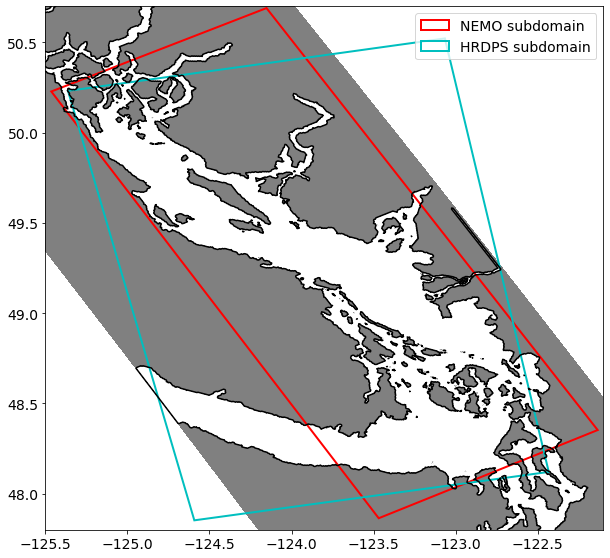

In [5]:
# Make figure panel
fig, ax = plt.subplots(figsize=(10, 10))

# Plot landmask
for func, color in zip(['contourf', 'contour'], ['gray', 'k']):
    getattr(ax, func)(
        GRIDS['NEMO'].longitude, GRIDS['NEMO'].latitude, GRIDS['Mask'].tmask[0, 0, ...],
        levels=[-0.01, 0.01], colors=color,
    )

# Plot subdomains
corners = [(2, 0), (2, 1), (3, 1), (3, 0)]
for model, shift, color in zip(['NEMO', 'HRDPS'], [0, 360], ['r', 'c']):
    XY = [(subdomains[model][j], subdomains[model][i]) for j, i in corners]
    lonlat = [(GRIDS[model].longitude[xy]-shift, GRIDS[model].latitude[xy]) for xy in XY]
    ax.add_patch(patches.Polygon(
        np.array(lonlat), fill=False, edgecolor=color, linewidth=2, label=f'{model} subdomain',
    ))

# Formatting
ax.set_xlim([-125.5, -122.1])
ax.set_ylim([47.8, 50.7])
ax.set_aspect(1.1)
ax.legend()
plt.show()

In [ ]:
# Initialize storage dicts
keys = [
    'ssh', 'sigma_theta', 'temperature', 'salinity',
    'nitrate', 'diatoms', 'ciliates', 'flagellates',
    'uVelocity', 'vVelocity', 'wVelocity',
]
tracers = dict((key, []) for key in keys)
wind = {'u_wind': [], 'v_wind': []}

# Loop through years
for y in range(2015, 2020):
    
    # Read HRDPS from erddap (whole year)
    timerange = [datetime(y, 1, 1), datetime(y, 12, 31, 23)]
    for key in ['u_wind', 'v_wind']:
        wind[key].append(HRDPS.sel(time=slice(*timerange))[key].values)

    # Read NEMO data from erddap (monthly)
    for m in tqdm(range(1, 13), desc=f'Loading {y}'):
        
        # Define time window
        timerange = [datetime(y, m, d, h, 30) for d, h in zip([1, monthrange(y, m)[1]], [0, 23])]
        
        # Get ssh and sigma
        tracers['ssh'].append(NEMO['2D'].sel(time=slice(*timerange)).ssh.values)
        tracers['sigma_theta'].append(NEMO['Auxiliary'].sel(time=slice(*timerange)).sigma_theta.values)
        
        # Get physical tracers
        for key in ['temperature', 'salinity']:
            tracers[key].append(NEMO['Tracer'].sel(time=slice(*timerange))[key].values)
        
        # Get biological tracers
        for key in ['nitrate', 'diatoms', 'ciliates', 'flagellates']:
            tracers[key].append(NEMO['Biology'].sel(time=slice(*timerange))[key].values)
            
        # Get velocities
        for key in ['uVelocity', 'vVelocity', 'wVelocity']:
            tracers[key].append(NEMO[key[0]+'Grid'].sel(time=slice(*timerange))[key].values)

# Concatenate
for key in wind: wind[key] = (['time', 'y', 'x'], np.concatenate(wind[key]))
for key in tracers: tracers[key] = (['time', 'y', 'x'], np.concatenate(tracers[key]))

# Output to netCDF
for model, ds, variables, in zip(['HRDPS', 'SalishSea'], [HRDPS, NEMO['2D']], [wind, tracers]):
    fn = results_path + f'{model}_1h_20150101_20191231.nc'
    coords = {'time': ds.sel(time=slice('2015 Jan 1', '2019 Dec 31')).time}
    xr.Dataset(tracers, coords=coords).to_netcdf(fn)